# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in super market settings to build a system that can identify products on store shelves.
An example of how this system could be used would be to assist visually impaired customers or automate common store management tasks like detecting low-stock or misplaced products, given an image of a shelf in a store.

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  dataset.zip
replace __MACOSX/._dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/._dataset      
  inflating: __MACOSX/dataset/._scenes  
  inflating: dataset/.DS_Store       
  inflating: __MACOSX/dataset/._.DS_Store  
  inflating: __MACOSX/dataset/._models  
  inflating: dataset/scenes/scene12.png  
  inflating: __MACOSX/dataset/scenes/._scene12.png  
  inflating: dataset/scenes/scene10.png  
  inflating: __MACOSX/dataset/scenes/._scene10.png  
  inflating: dataset/scenes/scene11.png  
  inflating: __MACOSX/dataset/scenes/._scene11.png  
  inflating: dataset/scenes/scene5.png  
  inflating: __MACOSX/dataset/scenes/._scene5.png  
  inflating: dataset/scenes/scene4.png  
  inflating: __MACOSX/dataset/scenes/._scene4.png  
  inflating: dataset/scenes/scene6.png  
  inflating: __MACOSX/dataset/scenes/._scene6.png  
  inflating: da

## Evaluation criteria
1. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

2. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed approach.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from scipy.stats import iqr
from math import sqrt, log
from warnings import filterwarnings
filterwarnings('ignore')

# Introduction
Given the task of Product Recognition, the overall idea of this project is to:
- detect possible matching on the scene given the reference; this is made using SIFT as detector and FLANN as matcher
- filter the results on the basis of their form and color, SIFT works on grayscale images.
- keep tracks of the best matches to discriminate false positives and improve most difficult matches

All the functions are explained and grouped in:
- Dataset loading and scene filtering
- Utility functions
- Filtering
- Candidates Detection
- Results


# Images filtering
Images are loaded into the notebook and since the scenes are affected by noise they have been filtered in the following way:
- a **median filter** to remove salt and pepper noise;
- a **bilateral filter** to remove gaussian noise.

In [3]:
def read_images(path, scene: bool):
  images = []
  if scene:
    for i in range(1, len(os.listdir(path))+1):
      img = cv2.imread(f'{path}scene{i}.png')
      img = filter_image(img)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      images.append(img)
  else:
    for i in range(1, len(os.listdir(path))+1):
      img = cv2.imread(f'{path}ref{i}.png')
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      images.append(img)
  return images

def filter_image(image):
  image = cv2.medianBlur(image, 9)
  image = cv2.medianBlur(image, ksize = 5)
  image = cv2.bilateralFilter(image, d=-1, sigmaColor=25, sigmaSpace=15)

  return image

In [4]:
reference_path = './dataset/models/'
scene_path = './dataset/scenes/'
def split_references(reference_path, scene_path):
  references = read_images(reference_path, False)
  scenes = read_images(scene_path, True)
  references_task_A, references_task_B = [ref for ref in references[:14]], [ref for ref in references[14:]]
  scenes_task_A, scenes_task_B = [scn for scn in scenes[:5]], [scn for scn in scenes[5:]]
  return references_task_A, references_task_B, scenes_task_A, scenes_task_B

references_task_A, references_task_B, scenes_task_A, scenes_task_B = split_references(reference_path, scene_path)

# Utility functions

- `check_euclidean_distance()` is used to check if two bounding box overlap and refer to the same matching

In [5]:
def check_euclidean_distance(point1, point2, threshold):
  distance = np.sqrt(np.power((point1[0] - point2[0]), 2) + np.power((point1[1] - point2[1]), 2))
  if distance < threshold:
      return True
  else:
      return False

- `angle_between_three_points()` is used to compute the angle of the bounding boxes points

In [6]:
def angle_between_three_points(a, b, c):
    ab = b - a
    bc = c - b

    dot_product = np.dot(ab, bc)
    magnitude_ab = np.linalg.norm(ab)
    magnitude_bc = np.linalg.norm(bc)

    cos_theta = dot_product / (magnitude_ab * magnitude_bc)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    angle = np.degrees(np.arccos(cos_theta))
    return angle

- `compute_patch()` creates a **patch** around every keypoint, padding the image for those points that fall in its borders with a reflective behaviour

In [7]:
def compute_patch(point, image, patch_window):
  image_padded = image.copy()
  x, y = int(point[:, 0]), int(point[:, 1])

  if x < patch_window or y < patch_window or x + patch_window > image.shape[1] or y + patch_window > image.shape[0]:
    image_padded = cv2.copyMakeBorder(image_padded, patch_window, patch_window, patch_window, patch_window, cv2.BORDER_REFLECT)
    x += patch_window
    y += patch_window
  patch = image_padded[int(y)-patch_window: int(y)+patch_window, int(x)-patch_window: int(x)+patch_window]
  return patch

- `compute_center()` is used to compute the centroid of the bounding box

In [8]:
def compute_center(keypoint):
  origin = keypoint[0][0]
  h_ref = np.abs(keypoint[0] - keypoint[1])[0]//2
  w_ref = np.abs(keypoint[0] - keypoint[3])[0]//2
  return origin[0] + w_ref[0], origin[1] + h_ref[1]

- `hist_distance()` compute the difference between two patches, computing and comparing the respective histograms with the Bhattacharyya distance, whose bins have been computed using the `freedman_diaconis_bins()` function.

In [9]:
def hist_distance(ref_patch, scn_patch):
  ref_patch = cv2.cvtColor(ref_patch, cv2.COLOR_RGB2Lab)
  scn_patch = cv2.cvtColor(scn_patch, cv2.COLOR_RGB2Lab)

  ref_channels = cv2.split(ref_patch)
  scn_channels = cv2.split(scn_patch)

  hist_range = [0,255]
  bin = freedman_diaconis_bins(ref_patch, scn_patch)
  comparison = []

  for i in range(len(ref_channels)):
    ref_hist = cv2.calcHist([ref_channels[i]], [0], None, [bin[i]], hist_range)
    scn_hist = cv2.calcHist([scn_channels[i]], [0], None, [bin[i]], hist_range)
    comparison.append(cv2.compareHist(ref_hist, scn_hist, cv2.HISTCMP_BHATTACHARYYA))
  average_comparison = np.median(comparison)
  return average_comparison

- `freedman_diaconis_bins()` is a reimplementation of the Freedman–Diaconis rule. It computes a number of bin based on the average of the interqartile ranges of two images, solving the problem of comparing histograms with a different number of bins.

In [10]:
def freedman_diaconis_bins(image1, image2):
    bins_per_channel = []
    for i, channel_name in enumerate(['L', 'A', 'B']):
        channel1 = image1[:, :, i].flatten()
        channel2 = image2[:, :, i].flatten()
        range1 = channel1.max() - channel1.min()
        range2 = channel2.max() - channel2.min()
        min_range = min(range1, range2) if min(range1, range2) > 0 else 256
        q75_1, q25_1 = np.percentile(channel1, [75, 25])
        q75_2, q25_2 = np.percentile(channel2, [75, 25])
        iqr1 = q75_1 - q25_1
        iqr2 = q75_2 - q25_2
        mean_iqr = (iqr1 + iqr2) / 2
        h = 2 * mean_iqr / (len(channel1) ** (1/3))
        bins = int(np.ceil(min_range / h)) if h > 0 else 31
        bins_per_channel.append(bins)
    return bins_per_channel

#split the image along the y axis in n_patch patches
def split_image(image, n_patch):
  patch_list = []
  for i in range(n_patch):
    j = 1+i
    patch_list.append(image[int((i/n_patch)*image.shape[0]):int((j/n_patch)*image.shape[0]), :, :])
  return patch_list

- `plot_result()` shows the resulting bounding boxes as stated in the instructions. The parameter **task** is used to set up an index shift to discriminate the references of the task A from those of the task B

In [11]:
def plot_result(reference_dict, output_scene, scn_idx, ref_image, task):
  if task == 'B':
    shift_ref = 15
    shift_scn = 6
  else:
    shift_ref = 1
    shift_scn = 1
  for r in reference_dict.values():
      for c in r.keypoint_dict:
        label = f"{r.reference_index + shift_ref}"
        position = (r.keypoint_dict[c][0][0][0][0], r.keypoint_dict[c][0][0][0][1]+50)
        height = abs(r.keypoint_dict[c][0][0][0][1]-r.keypoint_dict[c][0][1][0][1])
        width = abs(r.keypoint_dict[c][0][0][0][0]-r.keypoint_dict[c][0][3][0][0])

        output_scene = cv2.polylines(output_scene, [np.int32(r.keypoint_dict[c][0])], True, color = (0, 255, 0), 	thickness = 4, 	lineType = cv2.LINE_AA)
        #output_scene = cv2.putText(output_scene, label, org = np.int32(position), fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 1.8, color = (0, 255, 0), thickness = 4, lineType = cv2.LINE_AA)

  plt.title(f"Scene {scn_idx + shift_scn}")
  plt.imshow(output_scene)
  plt.show()

  for r in reference_dict.values():
    if len(r.keypoint_dict) != 0:
      print(f'Product {r.reference_index + shift_ref} - {len(r.keypoint_dict)} instance found:')
      index = 1
      for c in r.keypoint_dict.keys():
        height = abs(r.keypoint_dict[c][0][0][0][1]-r.keypoint_dict[c][0][1][0][1])
        width = abs(r.keypoint_dict[c][0][0][0][0]-r.keypoint_dict[c][0][3][0][0])

        print(f'\tInstance {index} {{position: {int(c[0]), int(c[1])}, width: {int(width)}px, height: {int(height)}px}}')
        index += 1


# Filtering

In this section all those function used to compute filtering during the workflow have been listed and explained.

### Keypoint's patches color filtering
The functions below are the first filter applied during the algorithm. The keypoints matched between the scene and the reference are filtered out with an absolute comparison based on color similarity of the patches. The function `keypoint_color_filter()` first compute the patches around the keypoint, then using `euclidean_difference()` extracts the absolute difference, filtering those matches whose difference is higher than the threshold.

In [12]:
def euclidean_difference(ref_lab, scn_lab):
  ref_lab = cv2.cvtColor(ref_lab, cv2.COLOR_RGB2Lab)
  scn_lab = cv2.cvtColor(scn_lab, cv2.COLOR_RGB2Lab)
  ref_lab_mean = np.mean(ref_lab, axis=(0, 1))
  scn_lab_mean = np.mean(scn_lab, axis=(0, 1))
  return np.linalg.norm(ref_lab_mean - scn_lab_mean)

def keypoint_color_filter(ref, scn, ref_pts, scn_pts, patch_window, color_similarity_threshold):
  r_pts = []
  s_pts = []
  diff = []
  for keypoint_ref, keypoint_scn in zip(ref_pts, scn_pts):

    #compute the patch around the keypoint
    patch_ref = compute_patch(keypoint_ref, ref, patch_window)
    patch_scn = compute_patch(keypoint_scn, scn, patch_window)
    diff.append(euclidean_difference(patch_ref, patch_scn))
  for i in range(len(ref_pts)):
    if diff[i]<color_similarity_threshold:
      r_pts.append(ref_pts[i])
      s_pts.append(scn_pts[i])

  return r_pts, s_pts

### Candidates shape filtering
To address the problem of handling bounding boxes that are dissimilar from the references, the function `candidates_shape_filter()` is used to filter out the ones whose angles are not of 90 degrees with a tolerance.

In [13]:
def candidates_shape_filter(ref_in_scn, angle_threshold):
  corners = ref_in_scn.reshape(4, 2)

  angle1 = angle_between_three_points(corners[0], corners[1], corners[2])
  angle2 = angle_between_three_points(corners[1], corners[2], corners[3])
  angle3 = angle_between_three_points(corners[2], corners[3], corners[0])
  angle4 = angle_between_three_points(corners[3], corners[0], corners[1])

  # Check if all angles are approximately 90 degrees
  if (abs(angle1 - 90) < angle_threshold and abs(angle2 - 90) < angle_threshold and abs(angle3 - 90) < angle_threshold and abs(angle4 - 90) < angle_threshold):
    return True
  else:
    return False

### Candidates color filtering

The last filtering technique computes the color similarity between the reference and the detected bounding boxes. In particular, the function `candidates_color_filter()` divides the reference and the bounding box in **n** (40) patches along the vertical axis. Subsequentially, for each patch, it computes the similarity using the function `hist_distance()` and returns the median value.

In [14]:
def candidates_color_filter(image, original_points, width, height, ref, n_patch= 40):

  src_points = [original_points[0], original_points[3], original_points[2], original_points[1]]
  dst_points = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)
  src_points = np.array(src_points, dtype=np.float32)
  matrix = cv2.getPerspectiveTransform(src_points, dst_points)
  warped = cv2.warpPerspective(image, matrix, (width, height))

  patch_scn = split_image(ref, n_patch)
  patch_ref = split_image(warped, n_patch)
  diff = []
  for i in range(n_patch):
    lab_dist = hist_distance(patch_scn[i], patch_ref[i])
    diff.append(lab_dist)
  return np.mean(diff)

# Candidates Detection

`candidates_detection()` is the process of finding the candidates bounding boxes in the scene. It involves:
- detection of keypoints and descriptors using the **SIFT** algorithm received as input.
- matching computation using **FLANN** algorithm.
- "gently" filtering of the good matches using the function `keypoint_color_filter()`. "Gently" means that the threshold is quite high, indeed it wants only to remove those matches which are completely far away, but not discard too much keypoints that could compromise the bounding boxes computation.
- if enough matches have been found the *homography* and *perspectiveTransform* are computed to obtain the points for defining the bounding box on the scene.
- `candidates_shape_filter()` removes those boxes whose angles are different from 90 degrees, with a threshold of 36, which corresponds to a 30% tolerance. This threshold seems quite high but is used to keep also those bounding boxes which are harder to find with a correct shape.

In [15]:
def candidates_detection(ref, ref_idx, scn, scn_idx, sift):
  ref_in_scn = None
  kp_ref, des_ref = sift.detectAndCompute(ref, None)
  kp_scn, des_scn = sift.detectAndCompute(scn, None)

  #compute matches
  FLANN_INDEX_KDTREE = 1
  index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 2)
  search_params = dict(checks = 250)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  matches = flann.knnMatch(des_ref, des_scn, k=2)
  good_matches = []
  for (f, s) in matches:
    if f.distance < 0.8*s.distance:
      good_matches.append(f)

  ref_pts = np.float32([kp_ref[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
  scn_pts = np.float32([kp_scn[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
  ref_pts, scn_pts = keypoint_color_filter(ref, scn, ref_pts, scn_pts, patch_window = 35, color_similarity_threshold = 60)


  MIN_MATCH_COUNT = 10
  if len(ref_pts)> MIN_MATCH_COUNT:
    M, mask = cv2.findHomography(np.float32(ref_pts), np.float32(scn_pts), cv2.RANSAC, 5.0)

    if M is None:
      print()
      return ref_in_scn, 0

    h, w, c = ref.shape
    img_pts = np.float32([[0,0], [0,h-1], [w-1,h-1], [w-1,0]]).reshape(-1,1,2)
    ref_in_scn = cv2.perspectiveTransform(img_pts, M)

    if candidates_shape_filter(ref_in_scn, angle_threshold = 36):
      return ref_in_scn, len(ref_pts)
    else:
      return ref_in_scn, 0
  else:
    return ref_in_scn, 0

The `Reference` class has been created to keep track of references detected in the scene. It helps to have a more clear code both in the processes of discriminating similar references and in the plot of the final results.

In [16]:
class Reference:
  def __init__(self, keypoint, similarity_measure:int, reference_index:int):
    self.reference_index = reference_index
    self.keypoint_dict = {compute_center(keypoint) : (keypoint, similarity_measure)}

  def add_keypoint(self, keypoint, similarity_measure: int):
    center = compute_center(keypoint)
    self.keypoint_dict[center] = (keypoint, similarity_measure)

  def remove_keypoint(self, center: int):
    del self.keypoint_dict[center]
    #if the dictionary is empty return True, used to remove the reference from the reference list

  def check_correspondance(self, keypoint):
    centroid = compute_center(keypoint)
    for center in self.keypoint_dict.keys():
      if check_euclidean_distance(centroid, center, 150):
        return center
    return None

The function `check_best_match()` is used to update the dictionary of candidates bounding boxes, received as parameter on the basis of the color similairty measure. If the candidates have a higher color similarity than the threshold then it is discarded, otherwise the center of the bounding box is computed and used to search those references which are near enough using the `check_correspondance()`.  
If a correspondance is found, it has been decided whether to keep both the bounding boxes or discard one of them. In case no match correspondance has been found, it means no bounding boxes have ever been detected on that centroid, so it is new and a new instance of the class **Reference** is created and added to the dictionary.  
At the end, the function returns a flag to report whether the dictionary has been modified or not.

In [17]:
def check_best_match(ref_dict, ref_keypoint, color_sim, ref_idx, task):
  new_best = False
  no_match = True
  ref_dict_copy = ref_dict.copy()
  color_threshold = 0.48
  if color_sim < color_threshold:
    for ref in ref_dict.values():
      matched_center = ref.check_correspondance(ref_keypoint)
      if matched_center != None:
        no_match = False
        if abs(ref.keypoint_dict[matched_center][1] - color_sim) < 0.023 and ref_idx!=ref.reference_index:
          new_best = True
        elif ref.keypoint_dict[matched_center][1] > color_sim:
          if ref.remove_keypoint(matched_center):
            del ref_dict_copy[ref.idx]
          new_best = True
  else:
    no_match = False

  if new_best or no_match:
    if ref_idx in ref_dict_copy:
      ref_dict_copy[ref_idx].add_keypoint(ref_keypoint, color_sim)

    else:
      ref_dict_copy[ref_idx] = Reference(ref_keypoint, color_sim, ref_idx)

    return ref_dict_copy, True

  return ref_dict_copy, False

# Complete workflow

`instance_detection()`, given a list of scenes and references will return the detected references on those scenes. The idea is to iterate over all the references while a bounding box is found and a dictionary, *best_reference*, keeps track of the best references found in the scene on the basis of the color similarity measure.  
The candidate detection is performed twice in every iteration:
1. on the scene where the previously detected references have been masked -> *scn_masked*
2. on the clean scene, where will be masked only the detections of the reference under iteration -> *scn_clean*.  

If a new reference is detected on the scene, then the color_similarity is computed by `candidates_color_filter()` and `check_best_match()` to check whether the dictionary needs to be updated or not. At the end of every iteration *scn_masked* is updated if and only if the dictionary is updated as well.

In [18]:
def instance_detection(scene_image, ref_image, task):

  sift = cv2.SIFT_create(enable_precise_upscale=True, contrastThreshold= 0.02)

  for scn_idx, scn in enumerate(scene_image):
    scn_masked = np.copy(scn)
    best_reference = {}

    for ref_idx, ref in enumerate(ref_image):
      scn_clean = np.copy(scn)
      while True:
        update_scn = False
        update_masked = False

        match_masked, n_masked_keypoint = candidates_detection(ref, ref_idx, scn_masked, scn_idx, sift)
        match_scn, n_scn_keypoint = candidates_detection(ref, ref_idx, scn_clean, scn_idx, sift)

        if n_scn_keypoint != 0:
          c = compute_center(match_scn)
          color_diff = candidates_color_filter(scn.copy(), np.int32(match_scn), ref.shape[1], ref.shape[0], ref)
          best_reference, update_scn = check_best_match(best_reference, match_scn, color_diff, ref_idx, task)
          scn_clean = cv2.fillPoly(scn_clean, [np.int32(match_scn)], (0,0,0))

        if n_masked_keypoint != 0:
          c = compute_center(match_masked)
          color_diff = candidates_color_filter(scn.copy(), np.int32(match_masked), ref.shape[1], ref.shape[0], ref)
          best_reference, update_masked = check_best_match(best_reference, match_masked, color_diff, ref_idx, task)

        if update_scn or update_masked:
          scn_masked = scn.copy()
          for r in best_reference.values():
            for c in r.keypoint_dict:
                scn_masked = cv2.fillPoly(scn_masked, [np.int32(r.keypoint_dict[c][0])], (0,0,0))

        if n_scn_keypoint == 0 and not(update_masked):
          break

    output_scn = scn.copy()
    plot_result(best_reference, output_scn, scn_idx, ref_image, task)

# Results

## Task A

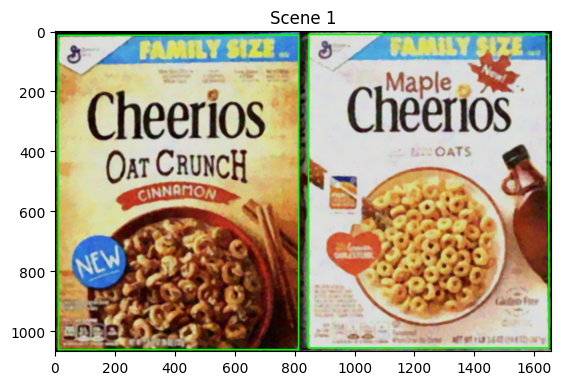

Product 1 - 1 instance found:
	Instance 1 {position: (411, 538), width: 803px, height: 1048px}
Product 2 - 1 instance found:
	Instance 1 {position: (1246, 533), width: 799px, height: 1045px}


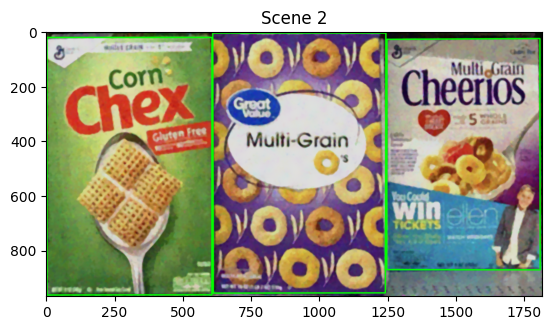

Product 3 - 1 instance found:
	Instance 1 {position: (304, 493), width: 603px, height: 940px}
Product 4 - 1 instance found:
	Instance 1 {position: (926, 481), width: 633px, height: 949px}
Product 5 - 1 instance found:
	Instance 1 {position: (1527, 450), width: 559px, height: 841px}


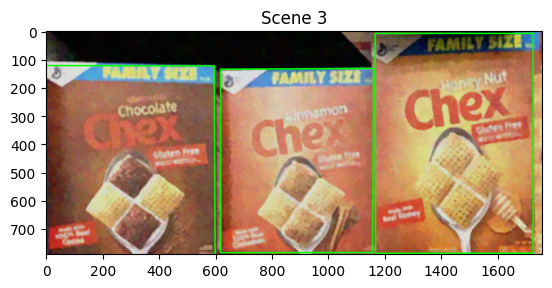

Product 6 - 1 instance found:
	Instance 1 {position: (296, 457), width: 599px, height: 671px}
Product 7 - 1 instance found:
	Instance 1 {position: (889, 460), width: 543px, height: 650px}
Product 8 - 1 instance found:
	Instance 1 {position: (1445, 397), width: 559px, height: 778px}


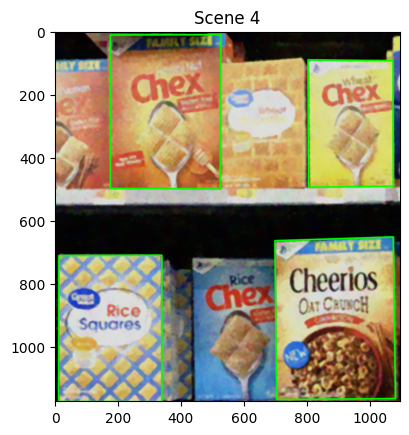

Product 1 - 1 instance found:
	Instance 1 {position: (883, 916), width: 374px, height: 503px}
Product 8 - 1 instance found:
	Instance 1 {position: (349, 255), width: 349px, height: 486px}
Product 9 - 1 instance found:
	Instance 1 {position: (174, 943), width: 325px, height: 463px}
Product 10 - 1 instance found:
	Instance 1 {position: (935, 293), width: 269px, height: 404px}


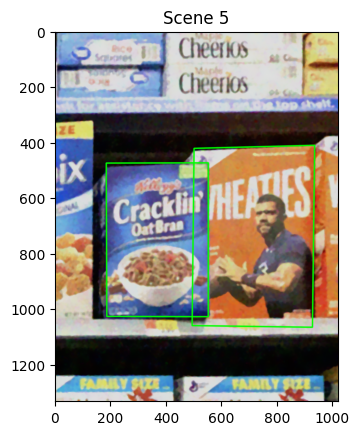

Product 11 - 1 instance found:
	Instance 1 {position: (367, 750), width: 367px, height: 551px}
Product 12 - 1 instance found:
	Instance 1 {position: (716, 740), width: 433px, height: 637px}


In [19]:
instance_detection(scenes_task_A, references_task_A, task= 'A')

## Task B

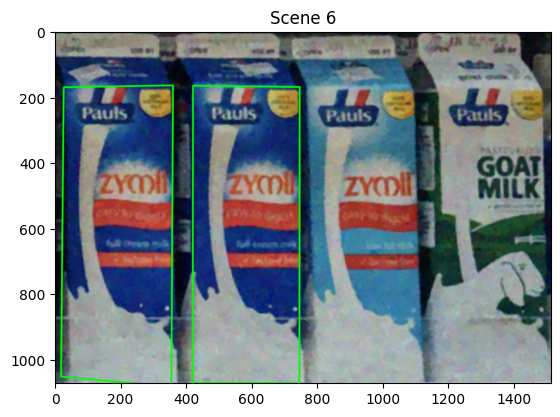

Product 15 - 2 instance found:
	Instance 1 {position: (582, 618), width: 324px, height: 905px}
	Instance 2 {position: (192, 611), width: 333px, height: 881px}


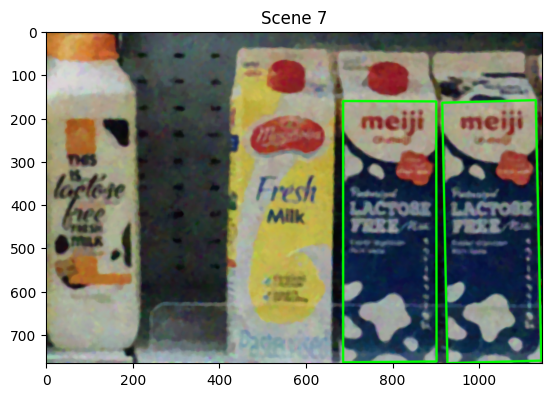

Product 16 - 2 instance found:
	Instance 1 {position: (793, 462), width: 215px, height: 603px}
	Instance 2 {position: (1022, 465), width: 215px, height: 601px}


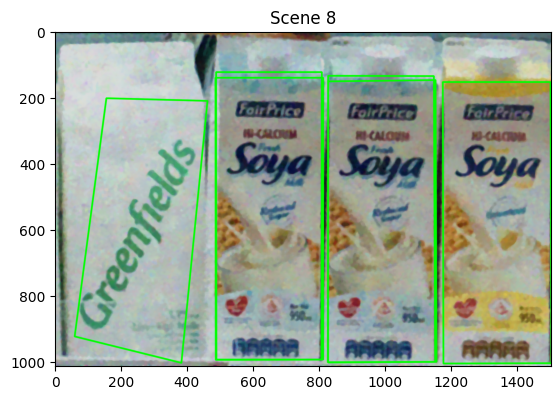

Product 17 - 2 instance found:
	Instance 1 {position: (647, 567), width: 325px, height: 853px}
	Instance 2 {position: (988, 576), width: 324px, height: 849px}
Product 23 - 2 instance found:
	Instance 1 {position: (985, 569), width: 319px, height: 868px}
	Instance 2 {position: (647, 559), width: 320px, height: 870px}
Product 24 - 1 instance found:
	Instance 1 {position: (1336, 579), width: 326px, height: 851px}
Product 27 - 1 instance found:
	Instance 1 {position: (308, 563), width: 306px, height: 720px}


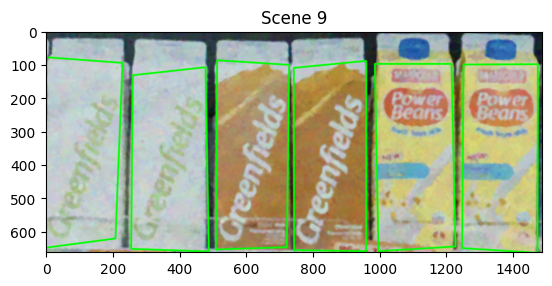

Product 18 - 2 instance found:
	Instance 1 {position: (113, 363), width: 231px, height: 570px}
	Instance 2 {position: (368, 392), width: 217px, height: 520px}
Product 19 - 2 instance found:
	Instance 1 {position: (851, 382), width: 217px, height: 545px}
	Instance 2 {position: (621, 370), width: 216px, height: 567px}
Product 20 - 2 instance found:
	Instance 1 {position: (1363, 374), width: 222px, height: 549px}
	Instance 2 {position: (1101, 378), width: 230px, height: 561px}


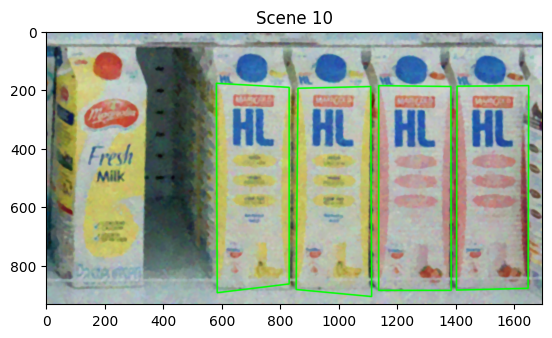

Product 21 - 2 instance found:
	Instance 1 {position: (706, 535), width: 249px, height: 715px}
	Instance 2 {position: (985, 538), width: 248px, height: 687px}
Product 22 - 2 instance found:
	Instance 1 {position: (1260, 535), width: 246px, height: 699px}
	Instance 2 {position: (1527, 536), width: 245px, height: 696px}


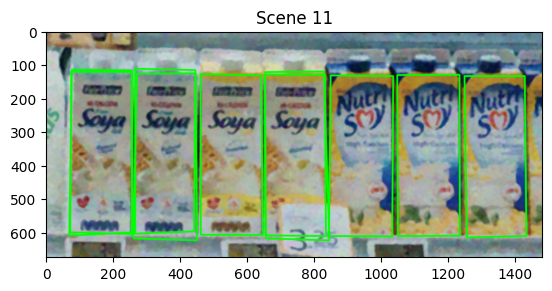

Product 17 - 2 instance found:
	Instance 1 {position: (166, 360), width: 183px, height: 478px}
	Instance 2 {position: (359, 372), width: 176px, height: 490px}
Product 23 - 3 instance found:
	Instance 1 {position: (166, 362), width: 179px, height: 494px}
	Instance 2 {position: (356, 358), width: 180px, height: 492px}
	Instance 3 {position: (742, 370), width: 176px, height: 496px}
Product 24 - 2 instance found:
	Instance 1 {position: (551, 367), width: 181px, height: 478px}
	Instance 2 {position: (742, 369), width: 179px, height: 480px}
Product 25 - 3 instance found:
	Instance 1 {position: (943, 371), width: 186px, height: 479px}
	Instance 2 {position: (1142, 370), width: 186px, height: 479px}
	Instance 3 {position: (1340, 374), width: 180px, height: 481px}




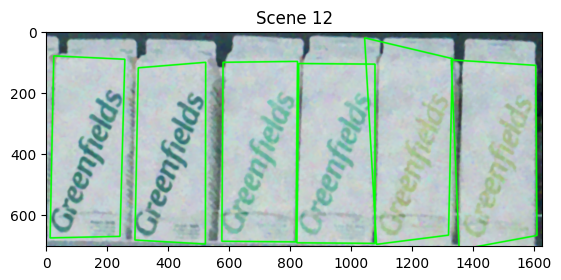

Product 18 - 2 instance found:
	Instance 1 {position: (1466, 404), width: 276px, height: 621px}
	Instance 2 {position: (1187, 360), width: 287px, height: 676px}
Product 26 - 2 instance found:
	Instance 1 {position: (412, 401), width: 221px, height: 563px}
	Instance 2 {position: (141, 379), width: 232px, height: 596px}
Product 27 - 2 instance found:
	Instance 1 {position: (953, 399), width: 250px, height: 586px}
	Instance 2 {position: (701, 394), width: 243px, height: 585px}


In [20]:
instance_detection(scenes_task_B, references_task_B, task= 'B')

# Conclusion

As we can see from the results, the algorithm almost achieves 100% of accuracy in both tasks, managing to success in it sometimes in the task B.  
It is possible to reach the perfection also in the task A by setting specific thresholds for each task. However, it has been taken the decision to keep a unique set of thresholds to guarantee a more general and solid algorithm that works well in any situation.